# Analysis of the Configuration Space
How good are the encodings, relatively, how unbalanced are the data labels?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

sys.path.append('.')

from plot_utils import fixEncs, seaborn_opts
from plot_utils import fig_width_in as WID

PARTIMES_PATH="../data/xtra-ankara/times_par10_to3600.csv.gz"

In [2]:
times = pd.read_csv(PARTIMES_PATH).loc[:,['ID','Encs','OverallTime']]
times

,ID,Encs,OverallTime
0,bacp/bacp-m1-05-c18-xcsp2018.param,ggt_ggt,0.927
1,bacp/bacp-m1-05-c18-xcsp2018.param,ggt_ggth,0.923
2,bacp/bacp-m1-05-c18-xcsp2018.param,ggt_gmto,0.920
3,bacp/bacp-m1-05-c18-xcsp2018.param,ggt_gpw,1.010
4,bacp/bacp-m1-05-c18-xcsp2018.param,ggt_lpw,1.014
...,...,...,...
50620,n_queens/queens-326.param,gmto_ggt,36000.000
50621,n_queens/queens-326.param,gpw_ggt,36000.000
50622,n_queens/queens-326.param,mdd_ggt,36000.000
50623,n_queens/queens-333.param,tree_ggt,36000.000


## How do the encoding configs compare?

### How often is each encoding config winning, and on what hardness of problem?

In [69]:
pd.set_option('display.max_rows',100)
SHOW = 20
winners = times.loc[times.groupby('ID')['OverallTime'].idxmin()]
win_report = winners.groupby('Encs',as_index=False).agg({'OverallTime':['mean','count','sum']})
win_report = win_report.reset_index(drop=True).sort_values(('OverallTime','count'),ascending=False)
win_report.columns = ['encs','mean_time','n_wins','vb_contrib']
league_wins = win_report.sort_values('n_wins',ascending=False)[:SHOW]
print(league_wins)
league_cont = win_report.sort_values('vb_contrib',ascending=False)[:SHOW]
league_cont['vb_pc'] = (100*(league_cont.vb_contrib / win_report.vb_contrib.sum())).round(1)
print(league_cont)
league_wins.to_csv("/tmp/lg_wins.csv",index=False)
league_cont.to_csv("/tmp/lg_cont.csv",index=False)
top_in_both = league_cont.loc[league_cont.encs.isin(league_wins.encs)]
print(top_in_both)

         encs   mean_time  n_wins  vb_contrib
71  tree_tree   46.426589      73    3389.141
53  rggt_tree  126.533000      31    3922.523
28    gpw_gpw  610.696231      26   15878.102
45   mdd_tree   30.164192      26     784.269
33   gpw_tree  148.188800      25    3704.720
8    ggt_tree   27.991583      24     671.798
38   lpw_tree    6.755762      21     141.871
16  ggth_tree   28.802571      21     604.854
62   swc_tree   16.851000      19     320.169
68   tree_mdd  153.489105      19    2916.293
30    gpw_mdd   15.751889      18     283.534
69  tree_rggt   20.779733      15     311.696
21   gmto_mdd   56.530857      14     791.432
66   tree_gpw   76.916462      13     999.914
63   tree_ggt   75.632727      11     831.960
25    gpw_ggt   75.707091      11     832.778
70   tree_swc   43.118636      11     474.305
31   gpw_rggt  223.187500      10    2231.875
26   gpw_ggth  361.563800      10    3615.638
49   rggt_gpw    7.319700      10      73.197
         encs   mean_time  n_wins 

## Performance Profile (Survival) Plot

In [70]:
# prepare data for plots
PLOT = 10
TIMEOUT = 3600
#label_encs = win_report.sort_values('vb_contrib', ascending=False).iloc[:PLOT]['encs'].tolist()
label_encs = top_in_both.encs.tolist()
print("Just labelling encodings",', '.join(label_encs))
frames = []
for encs in label_encs:
    goodtimes = times.loc[(times.OverallTime<TIMEOUT) & (times.Encs==encs)]
    t = goodtimes.loc[:,['OverallTime']].copy().reset_index(drop=True)
    encs_config = fixEncs(encs)
    enc_li, enc_pb = encs_config.split("_")
    t['time'] = sorted(t.OverallTime)
    t['encs'] = encs_config
    t['enc_li'] = enc_li
    t['enc_pb'] = enc_pb
    t['n_solved'] = list( range(1,len(t)+1) )
    frames.append(t.drop(columns=['OverallTime']))

plot_times = pd.concat(frames, ignore_index=True)
print("All entries:",len(plot_times))
plot_times = plot_times.groupby(['encs','enc_li','enc_pb','time'])['n_solved'].max().reset_index()
print("Without repeated times:",len(plot_times))

Just labelling encodings gpw_gpw, rggt_tree, gpw_tree, gpw_ggth, tree_tree, tree_mdd, gpw_rggt, tree_gpw
All entries: 4741
Without repeated times: 4700


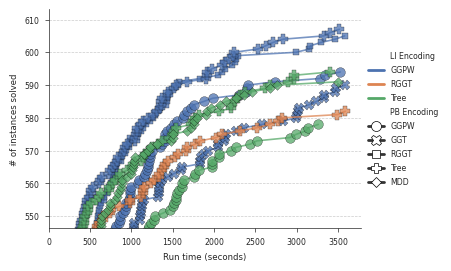

In [85]:
sns.set(**seaborn_opts)
fig,ax = plt.subplots(figsize=(WID,0.6*WID))
data = plot_times.rename(columns={'enc_li':'LI Encoding', 'enc_pb':'PB Encoding'})
sns.lineplot(ax=ax,data=data,x='time',y='n_solved',
             hue='LI Encoding',style='PB Encoding',
            markers=True, dashes=False, alpha=0.75,
            markeredgewidth=0.25, markersize=7, linewidth=1.2, markeredgecolor='black')
maxy = plot_times.loc[plot_times.time<=TIMEOUT]['n_solved'].max()
ax.set(ylim= (0.9*maxy, 1.01*maxy))
ax.set(xlim=(0,1.05*TIMEOUT))
ax.grid(axis='y', color="#cccccc", linestyle="--", linewidth=0.5)
ax.set(xlabel="Run time (seconds)", ylabel="# of instances solved")
for lh in ax.legend().legendHandles:
    lh.set_linewidth(2)
    lh.set_markeredgecolor('black')
    lh.set_markerfacecolor('white')
    lh.set_markeredgewidth(0.5)
sns.move_legend(ax,loc='center left',bbox_to_anchor=(1,0.5),title=None,
                framealpha=1,frameon=False,ncol=1,markerscale=1.5,labelspacing=0.64)
sns.despine(fig)
fig.tight_layout()
fig.savefig("/tmp/conf-space-race.pdf",dpi=1200)

In [58]:
plot_times.groupby('encs')['n_solved'].max().sort_values()

encs
Tree_GLPW    432
GGPW_GLPW    445
MDD_GMTO     552
Tree_GMTO    556
GLPW_GGTd    558
GLPW_GGPW    562
GGTd_GSWC    562
GSWC_GSWC    562
GGT_GSWC     563
GGTd_GGT     565
GGT_GGPW     565
MDD_GGTd     566
GSWC_GGT     566
RGGT_GGPW    567
GGTd_GGPW    568
RGGT_GGT     568
GSWC_GGPW    568
GGPW_GMTO    569
Tree_GSWC    570
GSWC_GGTd    571
Tree_GGT     572
GMTO_GGT     573
GLPW_MDD     575
Tree_GGTd    575
GLPW_Tree    577
GMTO_GGPW    577
Tree_GGPW    578
GSWC_Tree    579
GGT_Tree     581
GGTd_Tree    581
GGPW_GSWC    581
RGGT_Tree    582
MDD_Tree     583
GSWC_MDD     585
RGGT_MDD     585
GGTd_MDD     586
GGT_RGGT     586
GGT_MDD      586
GSWC_RGGT    587
GGPW_GGT     590
Tree_MDD     591
GGPW_GGTd    591
GMTO_Tree    592
GMTO_MDD     593
GGPW_GGPW    594
Tree_Tree    594
Tree_RGGT    595
GGPW_RGGT    605
GGPW_Tree    607
GGPW_MDD     607
Name: n_solved, dtype: int64

In [7]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
